In [2]:
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
%matplotlib inline
import matplotlib.pyplot as plt

# PDB轉成Dataframe

In [3]:
def organize(file): 
    with open(file,'r') as f:
        lines = []
        for line in f.readlines() :
            line = line.strip()
            line = line.split()
            lines.append(line)
    df = pd.DataFrame(lines,columns = list("abcdefghijk"),dtype=np.float64)
    df = df[["c","d","g","h","i"]]
    df.columns = ["element","amino","X","Y","Z"]
    df = df[df["element"].isin(["C","N","CA"])] #只抓取胺基酸主鍊N,CA,C
    df.index = range(1,len(df)+1) #index改成1開始
    return df 

# 向量長度

In [14]:
def longth(v):
    return np.sqrt(np.sum(v**2, dtype=np.float64))

# 兩向量計算夾角

In [15]:
def angle(v1,v2):
    cos = np.dot(v1,v2)/(longth(v1)*longth(v2))
    if cos > 0 : #+
        return -np.arccos(cos) 
    elif cos < 0 :#-
        return np.arccos(cos)

# A-B-C-D,計算AB、CD正射影角度

In [16]:
def p_angle(xarray): 
    a,b,c,d = xarray[0:4]
    vab = a - b
    vdc = d - c
    vbc = b - c
    vqb = vab - (np.dot(vab,vbc)/longth(vbc)**2)*vbc
    vpc = vdc - (np.dot(vdc,vbc)/longth(vbc)**2)*vbc
    return angle(vqb,vpc)    

In [28]:
if __name__ == "__main__":
    
    # 將pdb轉成dataframe
    file1 = r"C:\Users\z9875\code\2jof.pdb"
    file2 = r"C:\Users\z9875\code\skp.pdb"
    df = organize(file2)
    
    # 向量
    df[["VX", "VY", "VZ"]] = df[["X", "Y", "Z"]].diff()
    
    # 鍵長
    df["longth"] = np.sqrt(np.sum((df[["VX", "VY", "VZ"]].values)**2, axis=1))
    
    # 鍵角
    df["bond_angle"] = np.NAN
    for i in range(2,len(df)):
        v1, v2 = df.loc[i:i+1, ("VX", "VY", "VZ")].values
        df.loc[i+1, "bond_angle"] = angle(-v1, v2)
        
    # phipsi    
    df["phipsi"] = np.NAN
    for i in range(1,len(df)-2) :
        x_array = df.loc[i:i+4, ("X","Y","Z")].values
        df.loc[i, "phipsi"] = p_angle(x_array)

In [29]:
df.head()

,element,amino,X,Y,Z,VX,VY,VZ,longth,bond_angle,phipsi
1,N,ALA,35.811,16.487,-8.781,NaN,NaN,NaN,NaN,NaN,2.881597
2,CA,ALA,35.511,16.768,-7.341,-0.300,0.281,1.440,1.497518,NaN,3.110461
3,C,ALA,36.565,16.254,-6.358,1.054,-0.514,0.983,1.530164,2.000627,-1.003633
4,N,ASP,36.510,16.731,-5.124,-0.055,0.477,1.234,1.324126,2.036520,2.255705
5,CA,ASP,37.437,16.287,-4.089,0.927,-0.444,1.035,1.458660,2.123758,2.822334


# 回推主鍊結構 假設a-b-c-d

In [48]:
if __name__ == "__main__":    
    df["AnsX"], df["AnsY"], df["AnsZ"] = np.NaN, np.NaN, np.NaN 
    df.loc[1:3, ("AnsX", "AnsY", "AnsZ")] = df.loc[1:3, ("X", "Y", "Z")].values 
    for i in range(4, len(df)+1):
        vba, vcb =  df.loc[i-2:i-1, ("VX", "VY", "VZ")].values #向量 vba, vcb
        axis1 = np.cross(-vba, vcb) # 第一個旋轉軸是 vab和Vcb的法向量
        anglebca = df.loc[i-1, "bond_angle"] # 角bca
        v_tmp = Quaternion(axis=axis1, angle=anglebca).rotate(-vcb) #向量Vcb以axis1為軸旋轉angle
        angle2 = df.loc[i-3, "phipsi"]
        v_tmp2 = Quaternion(axis=vcb, angle=angle2).rotate(v_tmp) # V_tmp以vcb為軸旋轉angle2
        vdc = v_tmp2 * (df.loc[i, "longth"]/df.loc[i-1, "longth"]) # v_tmp2乘以 vbc長/vcd長
        df.loc[i:i, ("AnsX", "AnsY", "AnsZ")] =  df.loc[i-1:i-1, ("X", "Y", "Z")].values + vdc
        df["error"] = np.sqrt(np.sum((df[["X","Y","Z"]].values - df[["AnsX","AnsY","AnsZ"]].values)**2, axis=1))
        #誤差
    ans = pd.DataFrame(df[["element", "X", "Y", "Z", "AnsX", "AnsY", "AnsZ", "error"]] )
    ans.loc[:, ("AnsX", "AnsY", "AnsZ")] = np.around(ans.loc[:, ("AnsX", "AnsY", "AnsZ")],decimals=3)

In [49]:
df.head(30)

,element,amino,X,Y,Z,VX,VY,VZ,longth,bond_angle,phipsi,AnsX,AnsY,AnsZ,error
1,N,ALA,35.811,16.487,-8.781,NaN,NaN,NaN,NaN,NaN,2.881597,35.811000,16.487000,-8.781000,0.000000
2,CA,ALA,35.511,16.768,-7.341,-0.300,0.281,1.440,1.497518,NaN,3.110461,35.511000,16.768000,-7.341000,0.000000
3,C,ALA,36.565,16.254,-6.358,1.054,-0.514,0.983,1.530164,2.000627,-1.003633,36.565000,16.254000,-6.358000,0.000000
4,N,ASP,36.510,16.731,-5.124,-0.055,0.477,1.234,1.324126,2.036520,2.255705,36.472412,16.757160,-5.136703,0.047524
5,CA,ASP,37.437,16.287,-4.089,0.927,-0.444,1.035,1.458660,2.123758,2.822334,37.489526,16.211013,-4.176460,0.127210
6,C,ASP,37.285,14.766,-3.975,-0.152,-1.521,0.114,1.532821,1.866897,-1.514136,37.560500,14.809856,-3.698698,0.392640
7,N,LYS,38.382,14.020,-4.022,1.097,-0.746,-0.047,1.327454,2.063560,2.432320,38.505143,14.248248,-4.047921,0.260640
8,CA,LYS,38.495,12.650,-3.571,0.113,-1.370,0.451,1.446745,2.196511,2.818945,38.309297,12.663834,-3.523404,0.192204
9,C,LYS,38.830,12.538,-2.068,0.335,-0.112,1.503,1.543949,1.970458,2.348771,38.819103,12.195727,-2.131427,0.348271
10,N,ILE,38.205,11.591,-1.368,-0.625,-0.947,0.700,1.333204,2.049845,2.435658,38.155374,11.563618,-1.457350,0.105811


In [32]:
ans.tail()

,element,X,Y,Z,AnsX,AnsY,AnsZ,error
1265,CA,17.220,2.156,14.835,17.215,2.064,14.771,0.112437
1266,C,16.406,1.049,15.480,16.534,1.022,15.574,0.161253
1267,N,16.941,-0.159,15.521,17.018,-0.123,15.477,0.095897
1268,CA,16.235,-1.274,16.135,16.167,-1.217,16.154,0.090520
1269,C,16.965,-1.763,17.407,15.740,-2.470,15.289,2.546583


In [51]:
total_error = np.sum(df[["error"]].values)
total_error

529.3238606157777

In [52]:
#ans.to_csv("ans2jof.csv", index = True)


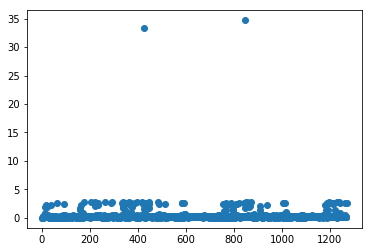

In [55]:
x = np.linspace(1,len(ans),len(ans))
plt.scatter(x, df.error)

In [40]:
mask = df["error"]>1.5
mask2 = df["amino"] == "ALA"

In [41]:
df[mask]

,element,amino,X,Y,Z,VX,VY,VZ,longth,bond_angle,phipsi,AnsX,AnsY,AnsZ,error
12,C,ILE,38.440,10.234,0.571,0.324,-1.382,0.465,1.493695,1.856638,2.433435,36.846284,11.339583,0.842574,1.958570
15,C,ALA,39.419,9.277,3.842,-0.063,0.295,1.487,1.517288,1.876561,2.176842,40.860114,8.677471,2.911979,1.816916
18,C,ILE,40.833,7.404,6.503,1.246,-0.766,0.505,1.547352,1.950148,2.333261,38.598825,7.382398,6.891023,2.267722
21,C,VAL,41.947,6.825,9.867,-0.369,-0.253,1.463,1.529882,1.954445,-1.464131,43.481482,7.784426,9.099093,1.965913
36,C,LEU,48.472,3.987,14.994,1.051,0.522,0.950,1.509829,1.871616,-1.272603,47.510064,4.505267,12.953359,2.314765
63,C,GLY,60.133,2.110,20.081,-0.345,0.945,1.141,1.521161,2.028069,-0.817310,61.838914,0.485409,18.940530,2.617271
90,C,PHE,61.067,2.332,34.220,0.065,-1.197,0.930,1.517213,1.985499,-1.130853,59.608372,4.126404,33.236674,2.512849
159,C,SER,50.794,-9.511,65.515,1.021,0.444,1.049,1.529699,1.906062,2.228651,51.073115,-10.758779,64.405838,1.692659
162,C,MET,50.785,-7.202,68.109,-0.852,0.603,1.118,1.529522,1.861434,-1.392322,52.440955,-6.522836,66.769302,2.235674
174,C,SER,57.172,-0.630,70.483,0.844,-0.422,-1.208,1.532868,1.950484,-1.102168,56.571056,1.037721,72.550527,2.723434


In [38]:
a = df.sort_values(by = "error")["error"]
type(a)

pandas.core.series.Series

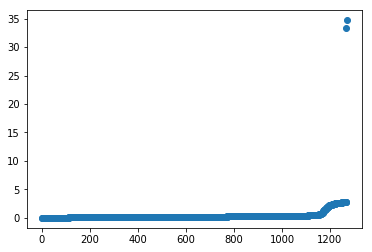

In [56]:
x = np.linspace(1, len(a), len(a))
plt.scatter(x, a)